In [1]:
import torch 
import torch.nn as nn
import torchvision
import torch.distributions as dist 
import matplotlib.pyplot as plt 
from main07 import SiameseNetwork, APP_MATCHER

In [72]:
def ishow(i1, i2): 
    # i1, i2: (1,1,28,28)
    bsize = i1.shape[0]
    fig, axes = plt.subplots(bsize,2, figsize=(4,bsize*2))
    if bsize == 1:
        axes[0].imshow(i1[0,0])
        axes[1].imshow(i2[0,0])
    else:
        for b in range(bsize):
            axes[b,0].imshow(i1[b,0])
            axes[b,1].imshow(i2[b,0])
    return axes 

In [3]:
model = SiameseNetwork()

modelfile = "siamese_network_07.pt"
model.load_state_dict(torch.load(modelfile))
model.eval()

SiameseNetwork(
  (resnet): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

torch.Size([1, 1, 28, 28]) tensor(255.) tensor(0.) <class 'torch.Tensor'>
tensor([[0.5009]]) same


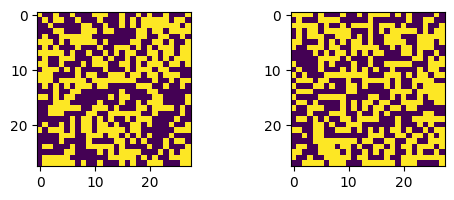

In [4]:
ber = dist.Bernoulli(probs=.5)
s = ber.sample(sample_shape=(1,1,28,28)) * 255
print(s.shape, s.max(), s.min(), type(s))

image_1 = ber.sample(sample_shape=(1,1,28,28)) * 255
image_2 = ber.sample(sample_shape=(1,1,28,28)) * 255
ishow(image_1, image_2)

with torch.no_grad(): 
    r = model(image_1, image_2)
    print(r, "different" if r < 0.5 else "same")

In [16]:
train_dataset = APP_MATCHER('../data', train=True, download=True)
test_dataset = APP_MATCHER('../data', train=False)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4)

In [17]:
d = test_dataset[0]
len(d), d[0].shape, d[0].max(), d[0].min(), type(d[0]), d[2], d[3]

(4,
 torch.Size([1, 28, 28]),
 tensor(255.),
 tensor(0.),
 torch.Tensor,
 tensor(1.),
 [8, 8])

<class 'torch.Tensor'> torch.Size([4, 1, 28, 28]) tensor(255.) tensor(0.) <class 'torch.Tensor'>
label: tensor([1., 0., 1., 0.]), selected_classes: [tensor([6, 2, 3, 8]), tensor([6, 7, 3, 2])]
tensor([[1.0000e+00],
        [1.8836e-08],
        [9.9999e-01],
        [1.9563e-06]])


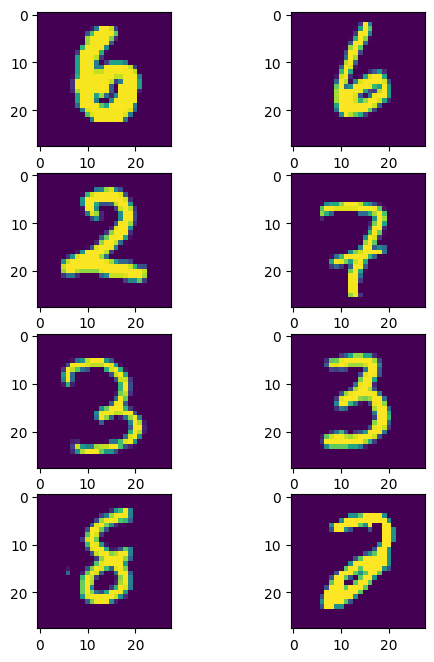

In [18]:
with torch.no_grad():
    for d in test_loader:
        i1, i2, label, scl = d 
        print(type(d[0]), d[0].shape, d[0].max(), d[0].min(), type(d[0]))
        print(f"label: {label}, selected_classes: {scl}")
        r = model(i1, i2)
        print(r)
        ishow(i1, i2)
        break 

In [68]:
import numpy as np
flag = False
with torch.no_grad():
    total = 0 
    acc = 0
    for d in test_loader:
        i1, i2, label, scl = d 
        scl = np.array([scl[0].numpy(), scl[1].numpy()])
        if flag:
            print(type(d[0]), d[0].shape, d[0].max(), d[0].min(), type(d[0]), label)
            print(f"label: {label}")
            print(f"selected_classes:\n", scl)

        choose = (scl[0] > 7) + (scl[1] > 7)
        
        r = model(i1, i2)
        rb = r.reshape(-1) > 0.5
        label = label.reshape(-1) > 0.5
        rcomp = label == rb 

        a = rcomp.int() * choose
        acc += a.sum() 
        total += choose.sum()
        
        if flag:
            print('pred    ', rb)
            print('gt      ', label)
            print('compare ', rcomp)
            print('choose  ', choose)
            print(a, a.sum())
            
        # break 
    print(f'{acc} / {total}', acc / total)

2235 / 2820 tensor(0.7926)


prediction: tensor([ True, False,  True, False])


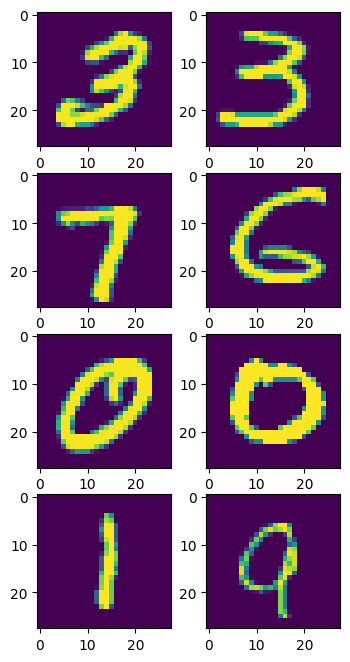

In [73]:
ishow(i1, i2);
print('prediction:', rb)

In [10]:
len(test_dataset)

10000

torch.Size([1, 1, 28, 28]) tensor(1.) 8


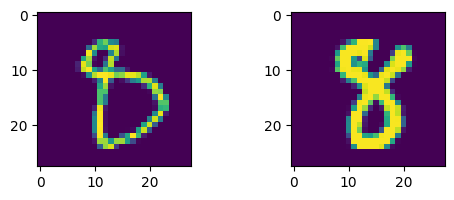

In [35]:
for k in range(len(test_dataset)):
    a, b, c = test_dataset[k]
    a = a.unsqueeze(0)
    b = b.unsqueeze(0)
    print(a.shape, c, test_dataset.selected_class)
    ishow(a, b)
    break 

In [50]:
a = scl[0] > 7
b = scl[1] > 7
a, b
a == b

array([ True,  True,  True, False])

In [52]:
a = (scl[0] > 7) * (scl[1] > 7)
a == b

array([ True,  True,  True, False])